# <center> <font style="color:rgb(100,109,254)"> Shape Detection Application   </font> </center>

In this notebook we are going to make a shape detection application, so what we'll do is we're gonna use `cv2.matchShapes()` to match shapes, first we'll read in a few shapes from the disk and save their contours, next we are gonna extract contours from a test image and label each contour with a shape's name.

In this notebook we are going to do shape detection on an image, in the next notebook we are also going to do shape detection on by drawing on Gui and on paper.

In [10]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

## <font style="color:rgb(134,19,348)">  Loading All shapes and saving their contours:  </font>
The first step is to load all shapes and save their contours.

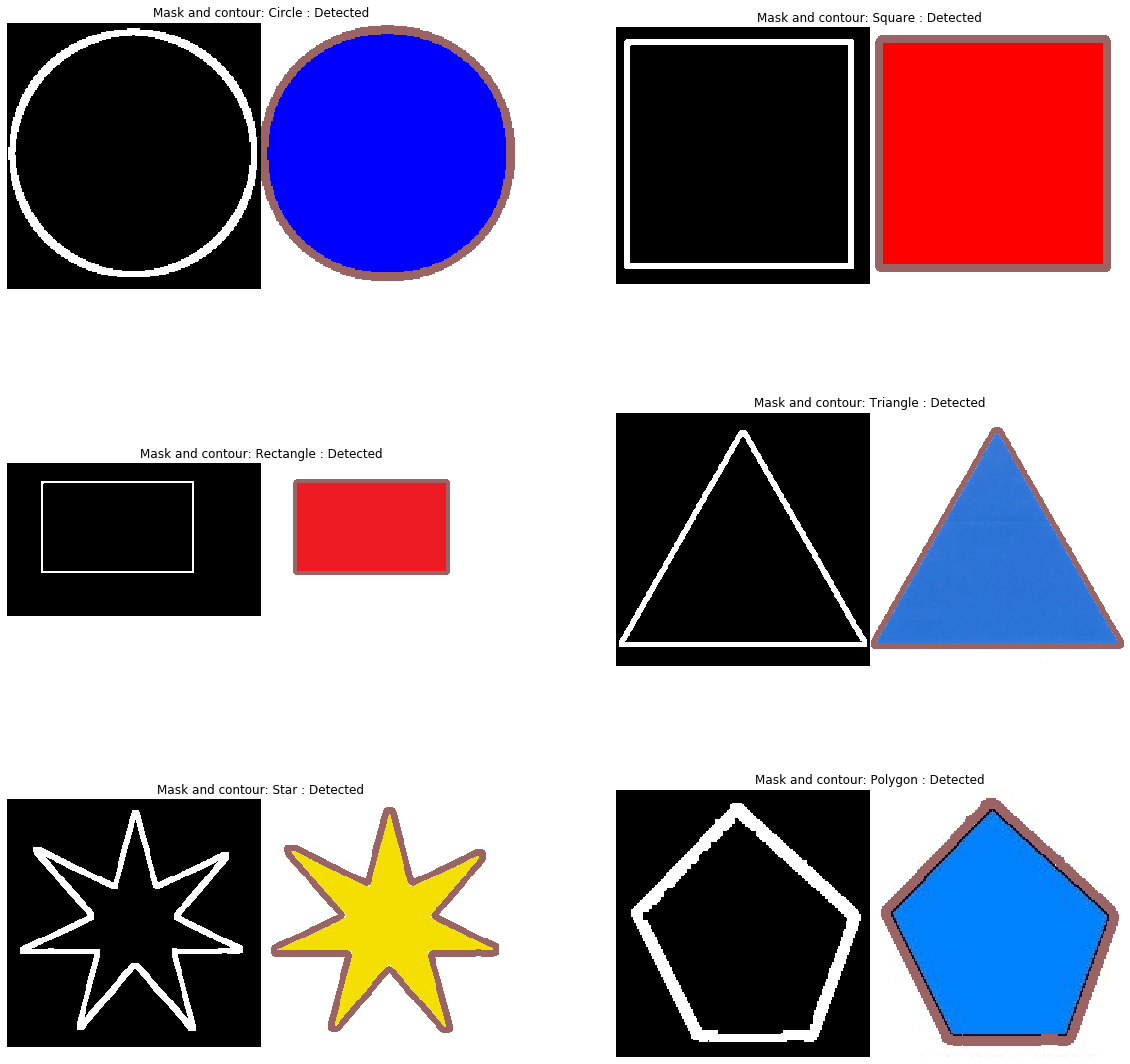

In [11]:
# Read all shape images from memory
circle =    cv2.imread(r'media/M12/shapeimages/circle.png',1)
square =    cv2.imread(r'media/M12/shapeimages/square.png',1)
rectangle = cv2.imread(r'media/M12/shapeimages/rect1.jpeg',1)
triangle =  cv2.imread(r'media/M12/shapeimages/triangle.jpg',1)
star =      cv2.imread(r'media/M12/shapeimages/star.jpg',1)
polygon =   cv2.imread(r'media/M12/shapeimages/polygon.jpg',1)

# Save all shapes in a list
allshapes = [circle, square, rectangle  ,triangle ,star, polygon]

# Save the names of all shapes in the same order.
shapenames= ['Circle','Square', 'Rectangle', 'Triangle', 'Star', 'Polygon']

# create a list for storing contours of each shape
allcontours=[]

# no of rows for plotting (divided by 2 cause we are using 2 columns)
rows = np.ceil(len(allshapes)/2)

# set figsize
plt.figure(figsize=[20,20])

# Now loop over all shapes
for index,shape in enumerate(allshapes):
    
    # perform edge detection
    mask = cv2.Canny(shape,100,300)
    
    # dilate the mask so there are no gaps in the main contour
    mask = cv2.dilate(mask,None,iterations = 2)
    
    # find contours
    contours, hierarchy = cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    
    # Make sure you detected a contour
    if contours:
        
        # state  = detected if you successfully detect a contour and vice versa.
        state = 'Detected'
        
        # Make sure you're extracting a single contour and the maximum one from the image
        c = max(contours, key = cv2.contourArea)

        # draw the contour over the shape (just for visualization)
        cv2.drawContours(shape, [c], 0, (100,100,155), 5)

        # Append the contour in the contour list.
        allcontours.append(c)
    
    else:
        state = 'Not Detected'
    
    # make the mask 3 channeled
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    
    # Stack mask and contour together
    stacked = np.hstack((mask,shape))
    
    # draw each contour with masks and their names.
    plt.subplot(rows,2,index+1);plt.imshow(stacked[:,:,::-1]);
    plt.title("Mask and contour: {} : {}".format(shapenames[index],state));plt.axis('off')        

## <font style="color:rgb(134,19,348)"> Shape Detector for Single Shape   </font>
Now first lets try to do the shape detection from an image containing a single shape. First we have to make sure that there is a valid shape contour detected on our test image. For this we will detect and display the contour of our test image.

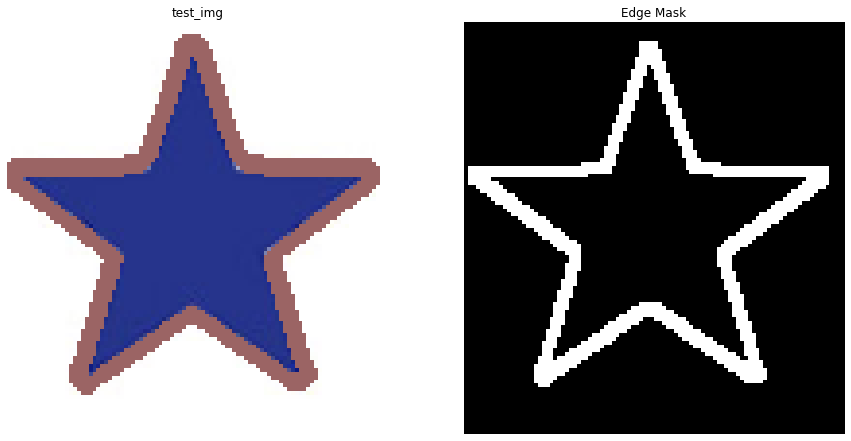

In [12]:
# Read the test image
test_image =  cv2.imread('media/M12/star1.png')

copy = test_image.copy()

# extract the edge mask
mask = cv2.Canny(test_image,100,300)

# dilate the mask so there are no gaps in the main contour (comment this line to see the gaps)
mask = cv2.dilate(mask,None,iterations = 1)

# detect contours
contours, hierarchy = cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

# make sure to get a single contour
test_contour = max(contours, key = cv2.contourArea)

# Draw contour on image
cv2.drawContours(copy, [test_contour], 0, (100,100,155), 3)

plt.figure(figsize=[15,15])
plt.subplot(1,2,1);plt.imshow(copy[:,:,::-1]);plt.title("test_img");plt.axis('off')
plt.subplot(1,2,2);plt.imshow(mask, cmap='gray');plt.title("Edge Mask");plt.axis('off');

Now after making sure that we have a valid contour, we can now test our test_contour with all the saved contours, and see who gives the best match i.e. lowest score with `cv2.matchShapes()` 

(-0.5, 97.5, 105.5, -0.5)

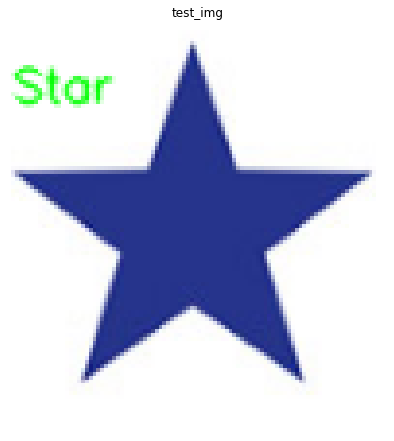

In [13]:
copy = test_image.copy()

# We will store all the match scores here. 
scores=[]

# Iterate over all saved contours and save their match scores
for cnt in allcontours:
   score = cv2.matchShapes(test_contour,cnt,1,0.0)
   scores.append(score)

# Grab the index of lowest scoring contour
pos = np.argmin(np.array(scores))

# Also grab the minimum score.
finalscore = min(scores)

# Make sure the lowest score is below some threshold so we can also label unkown shapes
thresh = 0.3
if finalscore < thresh:
    
    # set label of the detected shape using the index we got previously 
    label = shapenames[pos]
    
else:
    label = 'Unknown Shape'

# Label the image with the detected Label
cv2.putText(copy,label,(1,20), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 1, cv2.LINE_AA)

# display the image
plt.figure(figsize=[15,15])
plt.subplot(1,2,1);plt.imshow(copy[:,:,::-1]);plt.title("test_img");plt.axis('off')

**One important thing to know is that if you extract initial contours using one method, like canny then don't extract contours from a test image using a different method like thresholding, the problem here is that although the contours would be displayed same but they are stored differently in memory**

## <font style="color:rgb(134,19,348)"> Shape Detector for Multiple Shapes   </font>
Now lets take the above logic and expand it a bit, now we will make it work for an image containing multiple shapes, we will also draw bounding boxes around each shape. So the new addition we have to do is use an extra loop and utilize the `cv2.boundingrect()` function.

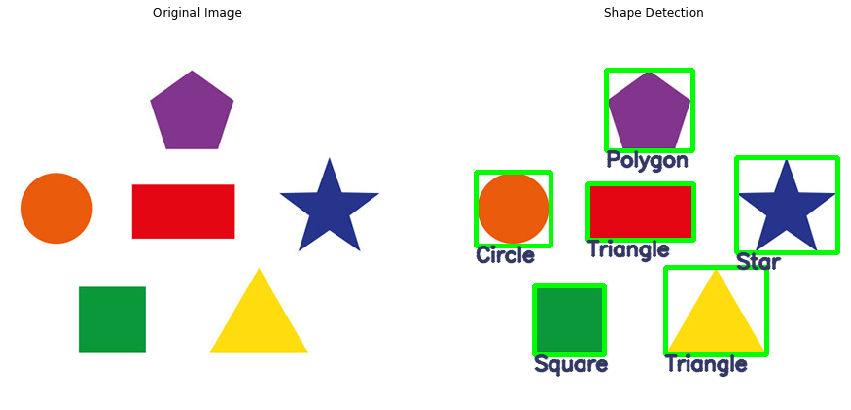

In [14]:
# Lets use an image we have containing multiple shapes.
test_image = cv2.imread('media/m12/shapescontour.jpg')  

original = test_image.copy()

# extract the edge mask
mask = cv2.Canny(test_image,100,300)

# dilate the mask so there are no gaps in the main contour (comment this line to see the gaps)
mask = cv2.dilate(mask,None,iterations = 1)

# detect contours
contours, hierarchy = cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)


thresh = 0.3
for test_contour in contours:
    
    # get a bounding box around each contour and draw it.
    x,y,w,h = cv2.boundingRect(test_contour)
    cv2.rectangle(test_image,(x,y),(x+w,y+h),(0,255,0),3)

    scores=[]

    # Now for each shape go over all saved contours and save the matchshape score
    for cnt in allcontours:
        score = cv2.matchShapes(test_contour,cnt,1,0.0)
        scores.append(score)

    # Grab the index of lowest scoring contour
    pos = np.argmin(np.array(scores))

    # Also grab the minimum score.
    finalscore = min(scores)

    # Make sure the lowest score is below some threshold so we can also label unkown shapes
    if finalscore < thresh:

        # set label of the detected shape using the index we got previously 
        label = shapenames[pos]

    else:
        label = 'Unknown Shape'


    cv2.putText(test_image, label, (x,y+h+16), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (100,55,50), 2, cv2.LINE_AA)

plt.figure(figsize=[15,15])
plt.subplot(1,2,1);plt.imshow(original[:,:,::-1]);plt.title("Original Image");plt.axis('off')
plt.subplot(1,2,2);plt.imshow(test_image[:,:,::-1]);plt.title("Shape Detection");plt.axis('off');

## <font style="color:rgb(134,19,348)">  Tkinter  </font>
Let me briefly introduce you to tkinter which is a Gui building library, its part of python standard built in libraries, so it comes pre-installed when you install python. Right now I'm going to show just one functionality of tkinter which is how to show a file selector. So you can select image from disk instead of writing image name every time for a new image.

In [15]:
# This is how you import the Tk module from the tkinter package
from tkinter import Tk

# Now from the filedialog module import the askoopenfilename method
from tkinter.filedialog import askopenfilename

# We prevent the root window from appearing
Tk().withdraw() 

# Call the method, after you select the filename it will store absolute path of file in the variable filename
filename = askopenfilename() 

# This is the path you will be passing to the imread funciton, for now we are just printing it.
print(filename)

C:/Users/hp-pc/ClassicalOfficial/Week 6 files/media/M12/cstar.jpg


**Note:** If you cancel the file selector after it pops up then the above cell may not run again and you may have to restart the kernel, if you're still having trouble opening up the tkinter file selector than try commenting the line `Tk().withdraw()`, if you're still facing problems then its better to use any other python IDE besides jupyter notebook.

## <font style="color:rgb(134,19,348)">Final Function    </font>
Lets put all the above logic in a single function.

In [16]:
def shape_detector(test_image = None, display = True, thresh = 0.3):
      
        # if the user has not specified any image then open up a file selector so that he can select a file.
        if test_image is None:
            Tk().withdraw() 
            filename = askopenfilename() 
            test_image = cv2.imread(filename)
            
        original = test_image.copy()
        
        # extract the edge mask
        mask = cv2.Canny(test_image,100,300)

        # dilate the mask so there are no gaps in the main contour (comment this line to see the gaps)
        mask = cv2.dilate(mask,None,iterations = 1)

        # detect contours
        contours, hierarchy = cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        
        if contours:
            for test_contour in contours:

                # get a bounding box around each contour and draw it.
                x,y,w,h = cv2.boundingRect(test_contour)
                cv2.rectangle(test_image,(x,y),(x+w,y+h),(0,255,0),3)

                scores=[]

                # Now for each shape go over all saved contours and save the matchshape score
                for cnt in allcontours:
                    score = cv2.matchShapes(test_contour,cnt,1,0.0)
                    scores.append(score)

                # Grab the index of lowest scoring contour
                pos = np.argmin(np.array(scores))

                # Also grab the minimum score.
                finalscore = min(scores)

                # Make sure the lowest score is below some threshold so we can also label unkown shapes
                if finalscore < thresh:

                    # set label of the detected shape using the index we got previously 
                    label = shapenames[pos]

                else:
                    label = 'Unknown Shape'


                cv2.putText(test_image, label, (x,y+h+16), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (100,55,50), 2, cv2.LINE_AA)
        else: 
            return None
        
        # if display is true then plot the image.
        if display:
            plt.figure(figsize=[15,15])
            plt.subplot(1,2,1);plt.imshow(original[:,:,::-1]);plt.title("Original Image");plt.axis('off')
            plt.subplot(1,2,2);plt.imshow(test_image[:,:,::-1]);plt.title("Shape Detection");plt.axis('off');
            
        else:
            return test_image

### <font style="color:rgb(134,19,348)">  Call our Function  </font>
We can now call our function with the default params, our method works on single and multiple shape images.

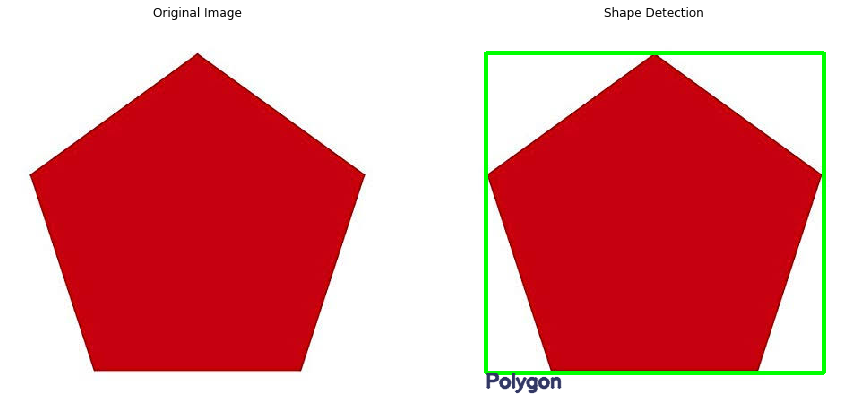

In [17]:
shape_detector()

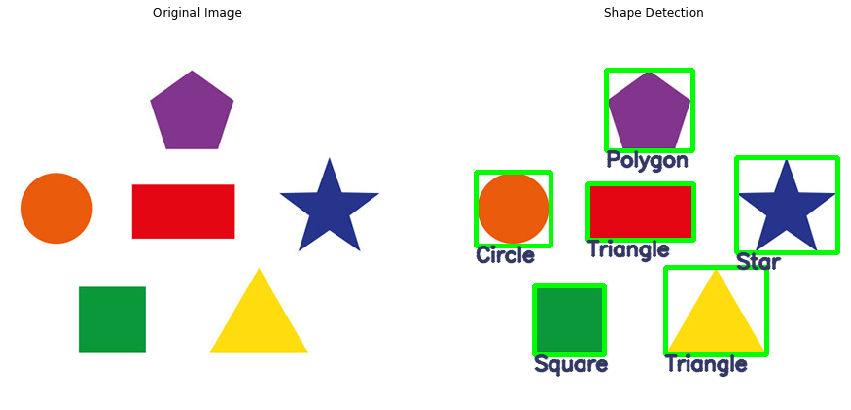

In [18]:
shape_detector()

besides this you also pass in the image you want the detection to be done and it can also return you the detected image without displaying.

###  <font style="color:rgb(34,169,134)"> Assignment: Number Classifier and detector </font>
Now your task is to do the same thing but with numbers from 0-9, so first store the contours of numbers and then predict them on new test image, note the variation between the test and stored image must not be too different.

In [ ]:
### ADD CODE HERE

